In [1]:
import sys
sys.path.append("..")
from tools.linear_regression.linear_regression import get_column, LinReg, correlation, dot
import pandas as pd
import os
import matplotlib.pyplot as plt
import math


#### Load Dataset
source: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv

In [2]:
dir_path = os.path.abspath('')
source = os.path.join(dir_path, 'data', 'Cars', 'car_details.csv')
df = pd.read_csv(source)

#### Remve units and change 'fields' dtype to float

In [3]:
def replace_convert(value, unit='', *args, **kwargs):
    if type(value) == str:
        if unit in value:
            value = value.replace(unit, '').strip()
            try:
                return float(value)
            except:
                return 0.0
        else:
            return float(value)
    else:
        return value        

def mileage(value):
    # 1 liter mean(LPG, gas) = approx. 730gr - thus, e.g., 730gr * 1.37 = 1,000.1
    if type(value) == str:
        if 'kmpl' in value:
            return float(value.replace('kmpl', '').strip())
        elif 'km/kg' in value:
            return float(value.replace('km/kg', '').strip()) * 1.37     
    else:
        return value



In [4]:
df['engine'] = df['engine'].apply(replace_convert, unit='CC')
df['max_power'] = df['max_power'].apply(replace_convert, unit='bhp')
df['mileage'] = df['mileage'].apply(mileage)

In [5]:
# util function that was run to determine levels of some variables
counts = {}
def count(value, counts):
    if type(value) == str:
        value = value.replace(' ', '_')
    if value in counts.keys():
        counts[value] += 1
    else: 
        counts[value] = 1
# results



#fuel = {'Diesel': 4402, 'Petrol': 3631, 'LPG': 38, 'CNG': 57}
#seller_type = {'Individual': 6766, 'Dealer': 1126, 'Trustmark_Dealer': 236}
#transmission = {'Manual': 7078, 'Automatic': 1050}
#owner = {'First_Owner': 5289, 'Second_Owner': 2105, 'Third_Owner': 555, 'Fourth_&_Above_Owner': 174, 'Test_Drive_Car': 5}

#### Convert categoricals to numericals

In [6]:
def numerical_fuel(value):
    if value == 'Diesel':
        return 0
    elif value == 'Petrol':
        return 1
    elif value == 'LPG' or value == 'CNG': 
        return 2
    else:
        return 2

def nummerical_seller(value):
    if value == 'Dealer' or value == 'Trustmark Dealer':
        return 1
    elif value == 'Individual':
        return 0
    else: 
        return 1

def numerical_trans(value):
    if value == 'Manual':
        return 0
    elif value == 'Automatic':
        return 1
    else:
        return 1
        

def numerical_owner(value):
    if value == 'First Owner':
        return 0
    elif value == 'Second Owner':
        return 1
    elif value == 'Third Owner':
        return 2
    elif value == 'Fourth & Above Owner':
        return 3
    elif value == 'Test_Drive_Car':
        return 4
    else:
        return 4



In [7]:
categorical = [('fuel', numerical_fuel), ('seller_type', nummerical_seller), ('transmission', numerical_trans), ('owner', numerical_owner)]
for col, func in categorical:
    df[col] = df[col].apply(func)

#### convert selling price
 no explanation in the dataset, but since the source is CarDheko, based in India and prices are indicated in LAKH, it is assumedthat the prices in the dataset are INR, because the mean is at 638000, which would equal 63,800,000,000 INR if converted from LAKH
 
100,000 INR equals 1342.73 USD (mid-market exchange rate at 10:45 UTC, Nov 3, 2021) will result in using a conversion rate of 74.5 (INR to USD) example selling_price: 290000 INR;  3,892.62 USD

In [8]:
def convert_to_USD(value):
    return value/74.5


In [9]:
df['selling_price'] = df['selling_price'].apply(convert_to_USD)

#### selling_price to python list to use as target variable/y in custom code

In [10]:
target = df['selling_price'].tolist()

#### change year to age (2020 - year) --> last update of dataset was 2020 -> conversion in order to make interpretation a little easier

In [11]:
def year_to_age(value):
    return 2021 - value
    

In [12]:
    df['age'] = df['year'].apply(year_to_age)

#### drop unwanted columns 
name is irrelevant, torque seems irrelevant as max_power is there (at early state), selling_price is used as target, year got changed to age

In [13]:
df.drop(labels=['selling_price', 'name', 'torque', 'year'], axis=1, inplace=True)

#### replace nan with mean vals

In [14]:
for col in df.columns:
    df[col].fillna(value=df[col].mean(), inplace=True)

#### create python list of x variables

In [15]:
x_vars = df.values.tolist()

#### prepare columns

In [16]:
tar_label = ['selling_price']
cols = [*tar_label, *df.columns]

#### get feel for data

##### visualize individual variables in relation to target

In [17]:
df.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,age
0,145500,0,0,0,0,23.40,1248.0,74.00,5.0,7
1,120000,0,0,0,1,21.14,1498.0,103.52,5.0,7
2,140000,1,0,0,2,17.70,1497.0,78.00,5.0,15
3,127000,0,0,0,0,23.00,1396.0,90.00,5.0,11
4,120000,1,0,0,0,16.10,1298.0,88.20,5.0,14


In [18]:
def plot_vars(x,y,labels=('', ''), save=False, line_fit=None, beta=[]):
    plt.scatter(x,y)
    plt.xlabel(labels[1])
    plt.ylabel(labels[0])
    plt.title(labels[0] + ' vs ' + labels[1])
    if line_fit != None and len(beta) > 0:
        plt.plot(x, [line_fit(xi, beta) for xi in x], color='red')
    if save:
        plt.savefig(f'results/Cars/{labels[0]}.png')
    plt.show()

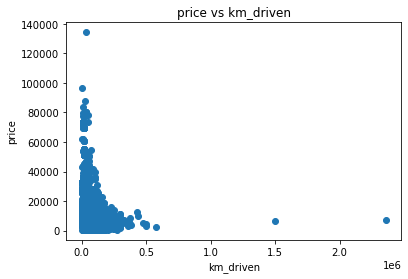

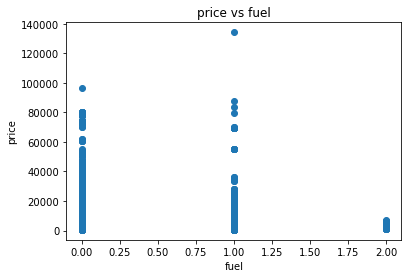

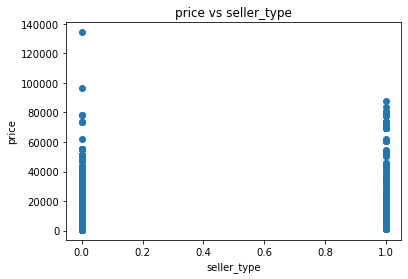

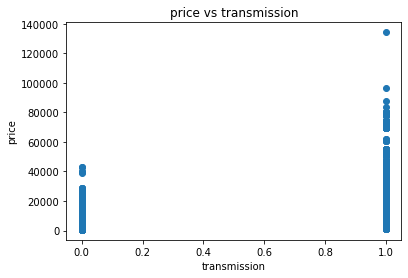

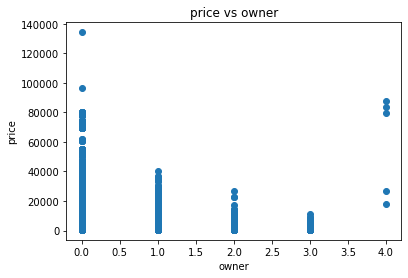

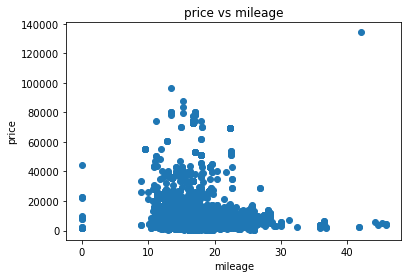

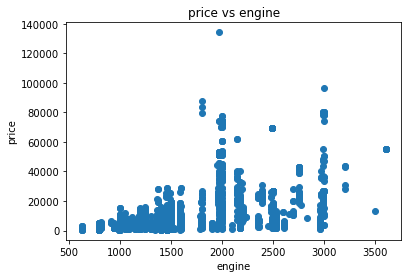

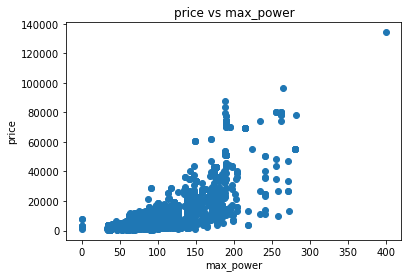

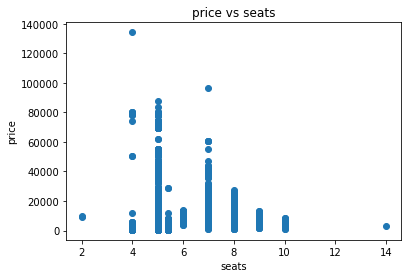

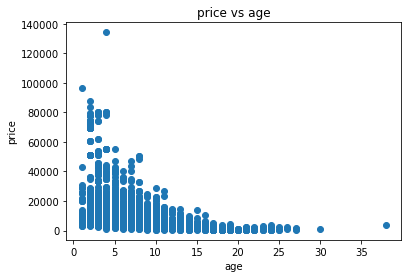

In [19]:
for i in range(len(x_vars[0])):
    x = get_column(x_vars, i)
    plot_vars(x, target, labels=('price', cols[i+1]))



##### run OLS with 1 var

In [20]:
def fit_line_lin(xi, beta):
    return beta[0] + beta[1]*xi

RESULTS FOR: selling_price vs. km_driven
CORRELATION COEFF:  -0.22553375557219008


 04/11/2021 22:18:49
|--------------------|--------------------|
|REGRESSION STATS    |                    |
|=========================================|
|R Square            |0.050865474902506036|
|--------------------|--------------------|
|Adj R Square        |0.050748672721223964|
|--------------------|--------------------|
|Multiple R          |0.22553375557221148 |
|--------------------|--------------------|
|Std Error Regression|10542.714658390649  |
|--------------------|--------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|-----------------|------------------|
|ANOVA     |DF   |SS               |MS                |
|=====================================================|
|Regression|1    |48415446325.31221|24207723162.656105|
|----------|-----|-----------------|------------------|
|Residual  |8126 |903417725745.096 |111176190.714385

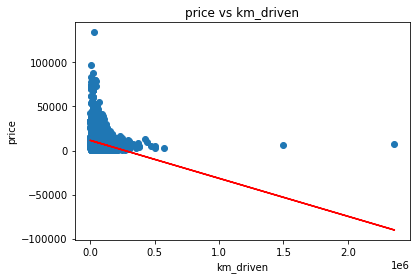

RESULTS FOR: selling_price vs. fuel
CORRELATION COEFF:  -0.2076164362650882


 04/11/2021 22:18:51
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.0431045846074255 |
|--------------------|-------------------|
|Adj R Square        |0.0429868273571925 |
|--------------------|-------------------|
|Multiple R          |0.20761643626511245|
|--------------------|-------------------|
|Std Error Regression|10585.729780688622 |
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|1    |41028373497.654625|20514186748.827312|
|----------|-----|------------------|------------------|
|Residual  |8126 |910804798572.7529 |112085257.0234744 |
|------

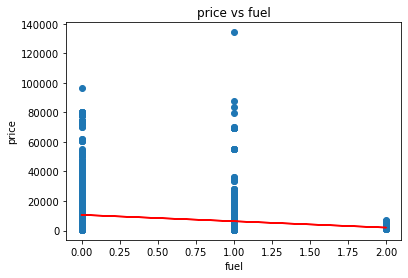

RESULTS FOR: selling_price vs. seller_type
CORRELATION COEFF:  0.3862441206059999


 04/11/2021 22:18:53
|--------------------|------------------|
|REGRESSION STATS    |                  |
|=======================================|
|R Square            |0.1491845207027227|
|--------------------|------------------|
|Adj R Square        |0.1490798178379309|
|--------------------|------------------|
|Multiple R          |0.3862441206060264|
|--------------------|------------------|
|Std Error Regression|9981.74009706828  |
|--------------------|------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|-----------------|------------------|
|ANOVA     |DF   |SS               |MS                |
|=====================================================|
|Regression|1    |141998775564.2376|70999387782.1188  |
|----------|-----|-----------------|------------------|
|Residual  |8126 |809834396506.1392|99659659.91953473 |
|----------|-----|

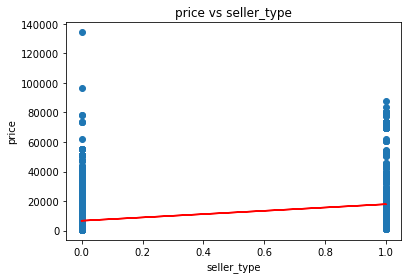

RESULTS FOR: selling_price vs. transmission
CORRELATION COEFF:  0.5888451675701393


 04/11/2021 22:18:55
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.3467386313706854 |
|--------------------|-------------------|
|Adj R Square        |0.34665823986580846|
|--------------------|-------------------|
|Multiple R          |0.5888451675701223 |
|--------------------|-------------------|
|Std Error Regression|8746.454740422972  |
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|1    |330037331376.94244|165018665688.47122|
|----------|-----|------------------|------------------|
|Residual  |8126 |621795840693.5021 |76519301.09445018 |


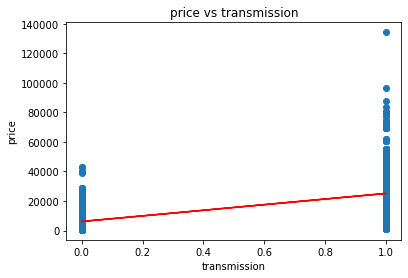

RESULTS FOR: selling_price vs. owner
CORRELATION COEFF:  -0.22191497642961563


 04/11/2021 22:18:56
|--------------------|--------------------|
|REGRESSION STATS    |                    |
|=========================================|
|R Square            |0.04924625676376926 |
|--------------------|--------------------|
|Adj R Square        |0.049129255318625775|
|--------------------|--------------------|
|Multiple R          |0.22191497642964356 |
|--------------------|--------------------|
|Std Error Regression|10551.703732187783  |
|--------------------|--------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|-----------------|------------------|
|ANOVA     |DF   |SS               |MS                |
|=====================================================|
|Regression|1    |46874220788.04851|23437110394.024254|
|----------|-----|-----------------|------------------|
|Residual  |8126 |904958951282.3636|111365856.66777796|


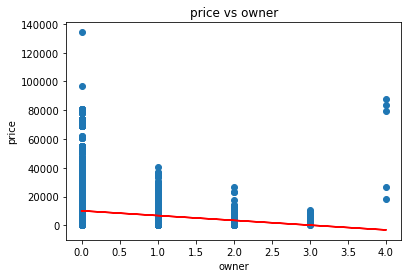

RESULTS FOR: selling_price vs. mileage
CORRELATION COEFF:  -0.1295223673472202


 04/11/2021 22:18:58
|--------------------|--------------------|
|REGRESSION STATS    |                    |
|=========================================|
|R Square            |0.016776043643240035|
|--------------------|--------------------|
|Adj R Square        |0.016655046355969927|
|--------------------|--------------------|
|Multiple R          |0.1295223673472657  |
|--------------------|--------------------|
|Std Error Regression|10730.37235460354   |
|--------------------|--------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|1    |15967994835.725569|7983997417.862784 |
|----------|-----|------------------|------------------|
|Residual  |8126 |935865177234.6794 |115169231.754

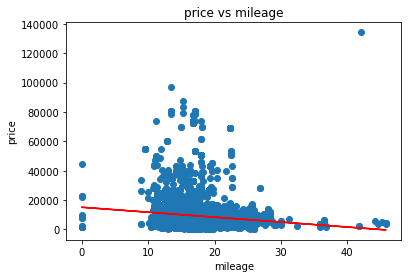

RESULTS FOR: selling_price vs. engine
CORRELATION COEFF:  0.45356672299895134


 04/11/2021 22:19:00
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.20572277221200141|
|--------------------|-------------------|
|Adj R Square        |0.2056250270449096 |
|--------------------|-------------------|
|Multiple R          |0.4535667229989447 |
|--------------------|-------------------|
|Std Error Regression|9644.38683702589   |
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|1    |195813758841.68323|97906879420.84161 |
|----------|-----|------------------|------------------|
|Residual  |8126 |756019413228.7473 |93037092.44754459 |
|----

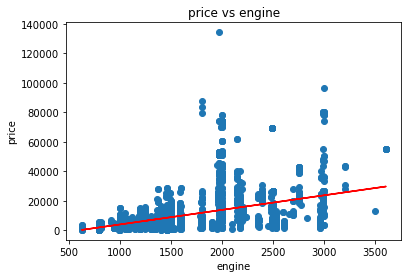

RESULTS FOR: selling_price vs. max_power
CORRELATION COEFF:  0.7448760868799577


 04/11/2021 22:19:01
|--------------------|------------------|
|REGRESSION STATS    |                  |
|=======================================|
|R Square            |0.5548403848056072|
|--------------------|------------------|
|Adj R Square        |0.5547856026723073|
|--------------------|------------------|
|Multiple R          |0.7448760868799637|
|--------------------|------------------|
|Std Error Regression|7220.153678268257 |
|--------------------|------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|-----------------|------------------|
|ANOVA     |DF   |SS               |MS                |
|=====================================================|
|Regression|1    |528115483462.2803|264057741731.14014|
|----------|-----|-----------------|------------------|
|Residual  |8126 |423717688608.1249|52143451.711558565|
|----------|-----|--

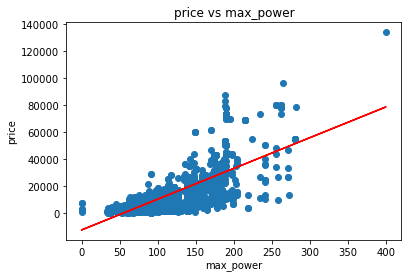

RESULTS FOR: selling_price vs. seats
CORRELATION COEFF:  0.04116112017989237


 04/11/2021 22:19:03
|--------------------|---------------------|
|REGRESSION STATS    |                     |
|==========================================|
|R Square            |0.0016942378144867432|
|--------------------|---------------------|
|Adj R Square        |0.001571384533390785 |
|--------------------|---------------------|
|Multiple R          |0.04116112018017419  |
|--------------------|---------------------|
|Std Error Regression|10812.35648066652    |
|--------------------|---------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|------------------|------------------|
|ANOVA     |DF   |SS                |MS                |
|======================================================|
|Regression|1    |1612631753.1825938|806315876.5912969 |
|----------|-----|------------------|------------------|
|Residual  |8126 |950220540317.2118 |1169

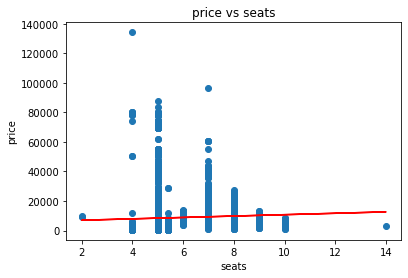

RESULTS FOR: selling_price vs. age
CORRELATION COEFF:  -0.4140918605571566


 04/11/2021 22:19:05
|--------------------|-------------------|
|REGRESSION STATS    |                   |
|========================================|
|R Square            |0.17147206897969092|
|--------------------|-------------------|
|Adj R Square        |0.17137010886019555|
|--------------------|-------------------|
|Multiple R          |0.4140918605571606 |
|--------------------|-------------------|
|Std Error Regression|9850.13410014536   |
|--------------------|-------------------|
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
|----------|-----|-----------------|------------------|
|ANOVA     |DF   |SS               |MS                |
|=====================================================|
|Regression|1    |163212803338.4142|81606401669.2071  |
|----------|-----|-----------------|------------------|
|Residual  |8126 |788620368731.9999|97049023.96406594 |
|----------|--

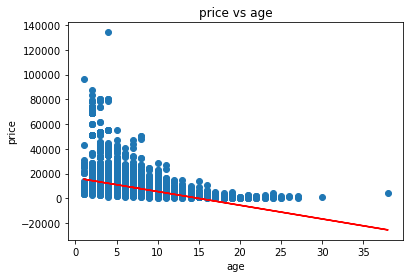

In [21]:

for i in range(len(x_vars[0])):
    var = get_column(x_vars, i)
    reg = LinReg(var, target, columns=[cols[0], cols[i+1]])
    reg.fit()
    print('RESULTS FOR: selling_price vs.', cols[i+1])
    print('CORRELATION COEFF: ', correlation(var, target))
    reg.analyse(report=True)
    plot_vars(var, target, labels=('price', cols[i+1]), line_fit=fit_line_lin, beta=reg.beta)

#### single variables variations

##### price and year

In [22]:
idx = cols.index('age') -1
age = get_column(x_vars, idx)
age_age_log = [1/i if i != 0 else 0 for i in age]




In [23]:
reg_age_log = LinReg(age_age_log, target, columns=['price', 'age', 'age_log'])
reg_age_log.fit()



[1963.7877727453379, 33426.71288769816]

In [24]:
def order(x,y, desc=False):
    data = list(zip(x,y))
    data.sort(key=lambda i:i[0],reverse=desc)
    return [d[0] for d in data], [d[1] for d in data]

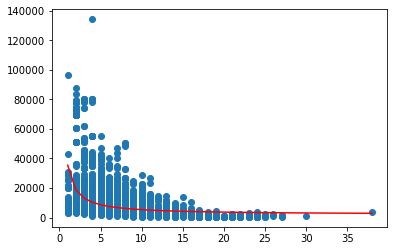

In [25]:
plt.scatter(get_column(x_vars, idx), target)
y_fl = [dot(xi, reg_age_log.beta) for xi in reg_age_log.x]
age_new, y_fl_new = order(age, y_fl)
plt.plot(age_new, y_fl_new, color='red')
plt.show()

conclusions: 
- one total outlier (max price) --> remove?
- year - polynominal 2nd order
- km_driven log?
- categoricals ???
- mileage -> seems less significant
- engine -> all over the place
- max_power slight poly - 2nd order
- seats -- seems less significant for price - but there seems a sort of distribution

#### further steps:
- remove outlier
- try with year, km_driven to start simple
- convert categoricals to dummy variables

#### remove outlier

In [26]:
idx = target.index(max(target))
#target.pop(idx)
#x_vars.pop(idx)




### fit & analyze with year and km_driven simple

In [27]:
print(cols[:3])

['selling_price', 'km_driven', 'fuel']


In [28]:
modified_x = [[i[0], i[1]] for i in x_vars]


In [29]:
reg_1 = LinReg( modified_x, target, columns=cols[:3])

In [30]:
reg_1.fit()

[15279.761120559888, -0.05674668914578659, -5850.475750286214]

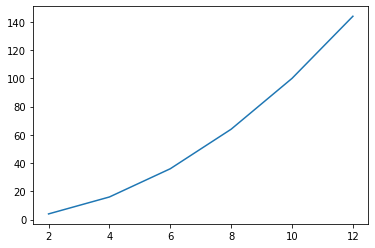

In [31]:
x = [10,2,4,6,8,12]
y = [i*i for i in x]
data = list(zip(x,y))
data.sort(key=lambda i:i[0],reverse=False)
x_new = [d[0] for d in data]
y_new = [d[1] for d in data]



plt.plot(x_new,y_new)
plt.show()